This notebook demonstrates voice activity detection from a microphone's stream (online) and a given wav file (offline)  in NeMo.

It is **not a recommended** way to do inference in production workflows. If you are interested in 
production-level inference using NeMo ASR models, please sign-up to Jarvis early access program: https://developer.nvidia.com/nvidia-jarvis

The notebook requires PyAudio library to get a signal from an audio device.
For Ubuntu, please run the following commands to install it:
```
sudo apt-get install -y portaudio19-dev
pip install pyaudio
```

In [1]:
import os
import nemo
import nemo.collections.asr as nemo_asr
import numpy as np
import pyaudio as pa
import time

################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################

/home/fjia/anaconda3/envs/vad/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/home/fjia/anaconda3/envs/vad/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' re

# Model Architecture and Weights

The model architecture is defined in a YAML file available in the config directory. MatchboxNet 3x1x64 has been trained on the Google Speech Commands dataset (v2) version, and these weights are available on NGC. They will automatically be downloaded if not found.

In [2]:
# [TODO] upload stuff to ngc!
# the checkpoints are available from NGC: https://ngc.nvidia.com/catalog/models/nvidia:google_speech_commands_v2___matchboxnet_3x1x1
MODEL_YAML = './configs/quartznet_vad_3x1_v1.yaml'

In [3]:
# Download the checkpoint files

base_checkpoint_path = '/home/fjia/code/NeMo-fei/examples/asr/quartznet_VAD_2balanced_o0_200ep_mfcc_prob88/results/quartznet_VAD_2balanced_o0_200ep_mfcc_prob88/1'
# base_checkpoint_path = './quartznet_VAD_2balanced_o0_200ep_mfcc_prob88/results/quartznet_VAD_2balanced_o0_200ep_mfcc_prob88/1'
CHECKPOINT_ENCODER = os.path.join(base_checkpoint_path, 'JasperEncoder-STEP-87000.pt')
CHECKPOINT_DECODER = os.path.join(base_checkpoint_path, 'JasperDecoderForClassification-STEP-87000.pt')

# if not os.path.exists(base_checkpoint_path):
#     os.makedirs(base_checkpoint_path)
    
# if not os.path.exists(CHECKPOINT_ENCODER):
#     !wget https://api.ngc.nvidia.com/v2/models/nvidia/google_speech_commands_v2___matchboxnet_3x1x1/versions/1/files/JasperEncoder-STEP-89000.pt -P {base_checkpoint_path};

# if not os.path.exists(CHECKPOINT_DECODER):
#     !wget https://api.ngc.nvidia.com/v2/models/nvidia/google_speech_commands_v2___matchboxnet_3x1x1/versions/1/files/JasperDecoderForClassification-STEP-89000.pt -P {base_checkpoint_path};

# Construct the Neural Modules and the eval graph

In [4]:
from ruamel.yaml import YAML
yaml = YAML(typ="safe")
with open(MODEL_YAML) as f:
    model_definition = yaml.load(f)

In [5]:
neural_factory = nemo.core.NeuralModuleFactory(
    placement=nemo.core.DeviceType.GPU,
    backend=nemo.core.Backend.PyTorch)

## Define a Neural Module to iterate over audio

Here we define a custom Neural Module which acts as an iterator over a stream of audio that is supplied to it. 

In [6]:
from nemo.backends.pytorch.nm import DataLayerNM
from nemo.core.neural_types import NeuralType, AudioSignal, LengthsType
import torch

# simple data layer to pass audio signal
class AudioDataLayer(DataLayerNM):
    @property
    def output_ports(self):
        return {
            'audio_signal': NeuralType(('B', 'T'), AudioSignal(freq=self._sample_rate)),
            'a_sig_length': NeuralType(tuple('B'), LengthsType()),
        }

    def __init__(self, sample_rate):
        super().__init__()
        self._sample_rate = sample_rate
        self.output = True
        
    def __iter__(self):
        return self
    
    def __next__(self):
        if not self.output:
            raise StopIteration
        self.output = False
        return torch.as_tensor(self.signal, dtype=torch.float32), \
               torch.as_tensor(self.signal_shape, dtype=torch.int64)
        
    def set_signal(self, signal):
        self.signal = np.reshape(signal.astype(np.float32)/32768., [1, -1])
        self.signal_shape = np.expand_dims(self.signal.size, 0).astype(np.int64)
        self.output = True

    def __len__(self):
        return 1

    @property
    def dataset(self):
        return None

    @property
    def data_iterator(self):
        return self

## Instantiate the Neural Modules

We now instantiate the neural modules and the encoder and decoder, set the weights of these models with the downloaded pretrained weights and construct the DAG to evaluate MatchboxNet on audio streams

In [7]:
# Instantiate necessary neural modules
data_layer = AudioDataLayer(sample_rate=model_definition['sample_rate'])

data_preprocessor = nemo_asr.AudioToMFCCPreprocessor(
    **model_definition['AudioToMFCCPreprocessor'])

jasper_encoder = nemo_asr.JasperEncoder(
    **model_definition['JasperEncoder'])

jasper_decoder = nemo_asr.JasperDecoderForClassification(
    feat_in=model_definition['JasperEncoder']['jasper'][-1]['filters'],
    num_classes=len(model_definition['labels']))

# load pre-trained model
jasper_encoder.restore_from(CHECKPOINT_ENCODER)
jasper_decoder.restore_from(CHECKPOINT_DECODER)

# Define inference DAG
audio_signal, audio_signal_len = data_layer()
processed_signal, processed_signal_len = data_preprocessor(
    input_signal=audio_signal,
    length=audio_signal_len)
encoded, encoded_len = jasper_encoder(audio_signal=processed_signal,
                                      length=processed_signal_len)
log_probs = jasper_decoder(encoder_output=encoded)

# inference method for audio signal (single instance)
def infer_signal(self, signal):
    data_layer.set_signal(signal)
    tensors = self.infer([log_probs], verbose=False)
    logits = tensors[0][0]
    return logits

neural_factory.infer_signal = infer_signal.__get__(neural_factory)

# FrameASR: Helper class for streaming inference

In [8]:
# class for streaming frame-based ASR
# 1) use reset() method to reset FrameASR's state
# 2) call transcribe(frame) to do ASR on
#    contiguous signal's frames
class FrameASR:
    
    def __init__(self, neural_factory, model_definition,
                 frame_len=2, frame_overlap=2.5, 
                 offset=10):
        '''
        Args:
          frame_len: frame's duration, seconds
          frame_overlap: duration of overlaps before and after current frame, seconds
          offset: number of symbols to drop for smooth streaming
        '''
        self.vocab = list(model_definition['labels'])
        self.vocab.append('_')
        
        self.sr = model_definition['sample_rate']
        self.frame_len = frame_len
        self.n_frame_len = int(frame_len * self.sr)
        self.frame_overlap = frame_overlap
        self.n_frame_overlap = int(frame_overlap * self.sr)
        timestep_duration = model_definition['AudioToMFCCPreprocessor']['window_stride']
        for block in model_definition['JasperEncoder']['jasper']:
            timestep_duration *= block['stride'][0] ** block['repeat']
        self.buffer = np.zeros(shape=2*self.n_frame_overlap + self.n_frame_len,
                               dtype=np.float32)
        self.offset = offset
        self.reset()
        
    def _decode(self, frame, offset=0):
        assert len(frame)==self.n_frame_len
        self.buffer[:-self.n_frame_len] = self.buffer[self.n_frame_len:]
        self.buffer[-self.n_frame_len:] = frame
        logits = neural_factory.infer_signal(self.buffer).to('cpu').numpy()[0]
        decoded = self._greedy_decoder(
            logits, 
            self.vocab
        )
        return decoded[:len(decoded)-offset]
    
    def transcribe(self, frame=None):
        if frame is None:
            frame = np.zeros(shape=self.n_frame_len, dtype=np.float32)
        if len(frame) < self.n_frame_len:
            frame = np.pad(frame, [0, self.n_frame_len - len(frame)], 'constant')
        unmerged = self._decode(frame, self.offset)
        
        return unmerged
    def reset(self):
        '''
        Reset frame_history and decoder's state
        '''
        self.buffer=np.zeros(shape=self.buffer.shape, dtype=np.float32)
        self.prev_char = ''

    @staticmethod
    def _greedy_decoder(logits, vocab):
        s = ''
        s = []
        if logits.shape[0]:
            probs = torch.softmax(torch.as_tensor(logits), dim=-1)
            probas, preds = torch.max(probs, dim=-1)
#             s += f"{preds.item():.4f}" + " " + str(vocab[preds])  + " " +  f"{probas.item():.4f}"+ " " + str(logits) +"\n"
            s = [preds.item(), str(vocab[preds]), probas.item(), str(logits)]
        return s

In [72]:
# duration of signal frame, seconds
FRAME_LEN = 0.05 #0.25 0.1 ##step
# number of audio channels (expect mono signal)
CHANNELS = 1
# sample rate, Hz
RATE = 16000
RATE = sample_rate

CHUNK_SIZE = int(FRAME_LEN*RATE)
asr = FrameASR(neural_factory, model_definition,
               frame_len=FRAME_LEN, frame_overlap=(0.5-FRAME_LEN)/2,  #2 0.45 1--FRAME_LEN)/2
               offset=0)

0.025 steps
0.5 window size

In [125]:
# duration of signal frame, seconds
FRAME_LEN = 0.025 #0.25 0.1  0.05  ##step
# number of audio channels (expect mono signal)
CHANNELS = 1
# sample rate, Hz
RATE = 16000
# RATE = sample_rate

CHUNK_SIZE = int(FRAME_LEN*RATE)
asr = FrameASR(neural_factory, model_definition,
               frame_len=FRAME_LEN, frame_overlap=(0.5-FRAME_LEN)/2,  #2 0.45 ###(1-FRAME_LEN)/2
               offset=0)

# What classes can this model recognize?

Before we begin inference on the actual audio stream, lets look at what are the classes this model was trained to recognize

In [11]:
labels = model_definition['labels']
print(labels)

['background', 'commands']


# Begin listening to audio stream and perform inference using FrameASR

In [12]:
# wave_file ='/home/fjia/data/freesound_resampled/Baby_cry/id_66637 cryingbabymerged.wav'
wave_file = '/home/fjia/data/freesound_resampled/Female_speech/id_328242 speech-female_hpsModel.wav'

In [87]:

import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
%matplotlib inline


# wave_file ='/home/fjia/data/freesound_resampled/Baby_cry/id_66637 cryingbabymerged.wav'
wave_file = 'haorizi_16_16.wav'

audio, sample_rate = librosa.load(wave_file)
ipd.Audio(audio, rate=RATE)


In [110]:
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
%matplotlib inline


wave_file = '/home/fjia/data/google_dataset_v2/google_speech_recognition_v2/left/02ade946_nohash_0.wav'
audio, sample_rate = librosa.load(wave_file)
ipd.Audio(audio, rate=RATE)



In [111]:
sample_rate

22050

## Offline

In [123]:
# wave_file ='/home/fjia/data/freesound_resampled/Baby_cry/id_66637 cryingbabymerged.wav'
wave_file = 'haorizi_noisy_16.wav'

audio, sample_rate = librosa.load(wave_file)
ipd.Audio(audio, rate=sample_rate)

In [126]:
import wave


wf = wave.open(wave_file, 'rb')
p = pa.PyAudio()

empty_counter = 0

preds = []
probas = []
def callback(in_data, frame_count, time_info, status):
    data = wf.readframes(frame_count)
    global empty_counter
    signal = np.frombuffer(data, dtype=np.int16)
    result = asr.transcribe(signal)
    
    preds.append(result[0])
    probas.append(result[2])
    if len(result):
        print(result,end='\n')
        empty_counter = 3
    elif empty_counter > 0:
        empty_counter -= 1
        if empty_counter == 0:
            print(' ',end='')
    
    return (data, pa.paContinue)

stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                channels=CHANNELS,
                rate=RATE,
                output = True,
                stream_callback=callback,
                frames_per_buffer=CHUNK_SIZE)

stream.start_stream()

while stream.is_active():
    time.sleep(0.1)
    
stream.stop_stream()
stream.close()
p.terminate()

asr.reset()
preds_025 = preds
probas_025 = probas

[0, 'background', 0.9954843521118164, '[ 2.696484  -2.6991858]']
[0, 'background', 0.9949668049812317, '[ 2.6420174 -2.6446314]']
[0, 'background', 0.9948428273200989, '[ 2.6297998 -2.6323943]']
[0, 'background', 0.9946625828742981, '[ 2.6125417 -2.6151087]']
[0, 'background', 0.9949213862419128, '[ 2.6375144 -2.6401212]']
[0, 'background', 0.9958581328392029, '[ 2.7398472 -2.7426188]']
[0, 'background', 0.9975966811180115, '[ 3.012657  -3.0158677]']
[0, 'background', 0.9983287453651428, '[ 3.1945105 -3.1980138]']
[0, 'background', 0.9994038343429565, '[ 3.7099962 -3.714329 ]']
[0, 'background', 0.9993143081665039, '[ 3.6400728 -3.6442933]']
[0, 'background', 0.999788224697113, '[ 4.2273054 -4.2324705]']
[0, 'background', 0.9997749924659729, '[ 4.1970935 -4.202211 ]']
[0, 'background', 0.9999610185623169, '[ 5.0725374 -5.0790634]']
[0, 'background', 0.999953031539917, '[ 4.9802675 -4.986645 ]']
[0, 'background', 0.9999889135360718, '[ 5.7026787 -5.7102184]']
[0, 'background', 0.9999613

[1, 'commands', 0.9999998807907104, '[-7.8719406  7.851327 ]']
[1, 'commands', 1.0, '[-8.608098  8.586638]']
[1, 'commands', 1.0, '[-9.059886  9.038044]']
[1, 'commands', 1.0, '[-8.8752165  8.853893 ]']
[1, 'commands', 1.0, '[-8.820093  8.798874]']
[1, 'commands', 0.9999998807907104, '[-8.032599  8.012723]']
[1, 'commands', 1.0, '[-8.577593  8.557141]']
[1, 'commands', 0.9999998807907104, '[-8.264934  8.244857]']
[1, 'commands', 0.9999986886978149, '[-6.7805376  6.7622423]']
[1, 'commands', 0.9934020638465881, '[-2.5146334  2.499754 ]']
[1, 'commands', 0.5360872745513916, '[-0.07891202  0.06568861]']
[0, 'background', 0.934842050075531, '[ 1.3257577 -1.3378055]']
[0, 'background', 0.9094672203063965, '[ 1.1475651 -1.1595814]']
[0, 'background', 0.79623943567276, '[ 0.67520165 -0.6877527 ]']
[1, 'commands', 0.9896104335784912, '[-2.2856266  2.2708783]']
[1, 'commands', 0.9997574687004089, '[-4.1703587  4.153655 ]']
[1, 'commands', 0.9999991655349731, '[-7.0434856  7.024822 ]']
[1, 'comm

[0, 'background', 0.9960781931877136, '[ 2.7671165 -2.7701561]']


In [138]:
import wave

def experiment_window_step(wave_file, STEP = 0.025, WINDOW_SIZE = 0.5 ):
    
    FRAME_LEN = STEP
    # duration of signal frame, seconds
#     FRAME_LEN = 0.025 #0.25 0.1  0.05  ##step
    # number of audio channels (expect mono signal)
    CHANNELS = 1
    # sample rate, Hz
    RATE = 16000
    # RATE = sample_rate

    CHUNK_SIZE = int(FRAME_LEN*RATE)
    asr = FrameASR(neural_factory, model_definition,
                   frame_len=FRAME_LEN, frame_overlap=(WINDOW_SIZE-FRAME_LEN)/2,  #2 0.45 ###(1-FRAME_LEN)/2
                   offset=0)


    wf = wave.open(wave_file, 'rb')
    p = pa.PyAudio()

    empty_counter = 0

    preds = []
    probas = []
    def callback(in_data, frame_count, time_info, status):
        data = wf.readframes(frame_count)
        global empty_counter
        signal = np.frombuffer(data, dtype=np.int16)
        result = asr.transcribe(signal)

        preds.append(result[0])
        probas.append(result[2])
        if len(result):
            print(result,end='\n')
            empty_counter = 3
        elif empty_counter > 0:
            empty_counter -= 1
            if empty_counter == 0:
                print(' ',end='')

        return (data, pa.paContinue)

    stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                    channels=CHANNELS,
                    rate=RATE,
                    output = True,
                    stream_callback=callback,
                    frames_per_buffer=CHUNK_SIZE)

    stream.start_stream()

    while stream.is_active():
        time.sleep(0.1)

    stream.stop_stream()
    stream.close()
    p.terminate()

    asr.reset()
    return preds, probas

In [146]:
wave_file = 'haorizi_16_16.wav'
preds_1, probas_1 = experiment_window_step(wave_file, STEP = 0.025, WINDOW_SIZE = 1.0)
print('===')
preds_05, probas_05 = experiment_window_step(wave_file, STEP = 0.025, WINDOW_SIZE = 0.5)
print('===')
preds_025, probas_025 = experiment_window_step(wave_file, STEP = 0.025, WINDOW_SIZE = 0.25)

[0, 'background', 0.999312162399292, '[ 3.638466  -3.6428752]']
[0, 'background', 0.9992017149925232, '[ 3.5639298 -3.56823  ]']
[0, 'background', 0.9986103773117065, '[ 3.28652   -3.2908678]']
[0, 'background', 0.9988747239112854, '[ 3.39224   -3.3963468]']
[0, 'background', 0.9985145926475525, '[ 3.2532773 -3.2572682]']
[0, 'background', 0.998650848865509, '[ 3.301533  -3.3053803]']
[0, 'background', 0.9977831244468689, '[ 3.052802 -3.056622]']
[0, 'background', 0.998044490814209, '[ 3.1157513 -3.1193836]']
[0, 'background', 0.9960747957229614, '[ 2.7663007 -2.7700818]']
[0, 'background', 0.9974310994148254, '[ 2.97914  -2.982568]']
[0, 'background', 0.9948676824569702, '[ 2.631712 -2.635333]']
[0, 'background', 0.9974300265312195, '[ 2.9789367 -2.9823437]']
[0, 'background', 0.9954401254653931, '[ 2.6912227 -2.6946838]']
[0, 'background', 0.9973682761192322, '[ 2.967075  -2.9703927]']
[0, 'background', 0.9949209094047546, '[ 2.6371415 -2.640401 ]']
[0, 'background', 0.99780255556106

[1, 'commands', 0.8072247505187988, '[-0.7242794  0.707798 ]']
[1, 'commands', 0.9240794777870178, '[-1.257849  1.241262]']
[1, 'commands', 0.955248236656189, '[-1.5387275  1.5221119]']
[1, 'commands', 0.9625983834266663, '[-1.6322944  1.6156282]']
[1, 'commands', 0.942030668258667, '[-1.4026039  1.3855193]']
[0, 'background', 0.7575236558914185, '[ 0.5617678 -0.5773828]']
[0, 'background', 0.9165781736373901, '[ 1.190247  -1.2064903]']
[0, 'background', 0.9616843461990356, '[ 1.603131  -1.6196954]']
[0, 'background', 0.9746248722076416, '[ 1.8154614 -1.8328223]']
[0, 'background', 0.9881552457809448, '[ 2.203935  -2.2200203]']
[0, 'background', 0.9517601132392883, '[ 1.4827807 -1.499347 ]']
[0, 'background', 0.9421404004096985, '[ 1.3869596 -1.4031744]']
[0, 'background', 0.9398131966590881, '[ 1.3658934 -1.3823338]']
[0, 'background', 0.9718831181526184, '[ 1.7631621 -1.7797027]']
[0, 'background', 0.9338147044181824, '[ 1.3146799 -1.33214  ]']
[0, 'background', 0.9159519076347351, '

[0, 'background', 0.9998893737792969, '[ 4.5518284 -4.557467 ]']
[0, 'background', 0.9999114274978638, '[ 4.6626663 -4.668483 ]']
[0, 'background', 0.9998947381973267, '[ 4.576867  -4.5825453]']
[0, 'background', 0.9998791217803955, '[ 4.5074663 -4.513044 ]']
[0, 'background', 0.9998900890350342, '[ 4.5551615 -4.5608053]']
[0, 'background', 0.999854326248169, '[ 4.414177  -4.4195933]']
[0, 'background', 0.999896764755249, '[ 4.586198  -4.5918913]']
[0, 'background', 0.9998700618743896, '[ 4.4713    -4.4768085]']
[0, 'background', 0.9999047517776489, '[ 4.6263275 -4.632086 ]']
[0, 'background', 0.9998533725738525, '[ 4.4112043 -4.4166164]']
[0, 'background', 0.999890923500061, '[ 4.558673 -4.564322]']
[0, 'background', 0.9998389482498169, '[ 4.3642693 -4.3696055]']
[0, 'background', 0.9997774958610535, '[ 4.202542  -4.2076178]']
[0, 'background', 0.9996788501739502, '[ 4.0192537 -4.024035 ]']
===
[0, 'background', 0.9957060217857361, '[ 2.7217398 -2.724482 ]']
[0, 'background', 0.995734

[1, 'commands', 0.8415356874465942, '[-0.84043694  0.829262  ]']
[1, 'commands', 0.6334347724914551, '[-0.27851605  0.26846457]']
[0, 'background', 0.5233237147331238, '[ 0.04187727 -0.0514853 ]']
[1, 'commands', 0.6023228168487549, '[-0.21236444  0.20278859]']
[0, 'background', 0.7152581214904785, '[ 0.4559772  -0.46508312]']
[1, 'commands', 0.6642179489135742, '[-0.34617066  0.33597755]']
[0, 'background', 0.5287889838218689, '[ 0.05249238 -0.06279111]']
[0, 'background', 0.7454283237457275, '[ 0.5322678  -0.54210854]']
[0, 'background', 0.9134190082550049, '[ 1.1736263 -1.1824877]']
[0, 'background', 0.9364194273948669, '[ 1.3409183 -1.3488369]']
[0, 'background', 0.9378539323806763, '[ 1.3532373 -1.3608696]']
[0, 'background', 0.9792619943618774, '[ 1.924491  -1.9303383]']
[0, 'background', 0.9943695664405823, '[ 2.58425   -2.5896747]']
[0, 'background', 0.9981722831726074, '[ 3.148867 -3.153964]']
[0, 'background', 0.9993200302124023, '[ 3.6435513 -3.6491647]']
[0, 'background', 0

[0, 'background', 0.9988262057304382, '[ 3.3713007 -3.3750885]']
[0, 'background', 0.9989075660705566, '[ 3.407189  -3.4110343]']
[0, 'background', 0.9985581040382385, '[ 3.2683504 -3.2719727]']
[0, 'background', 0.9983826875686646, '[ 3.210924  -3.2144537]']
[0, 'background', 0.9982591271400452, '[ 3.174087  -3.1775575]']
[0, 'background', 0.9981650710105896, '[ 3.1477375 -3.1511655]']
[0, 'background', 0.9983066320419312, '[ 3.1879237 -3.1914163]']
[0, 'background', 0.9970452189445496, '[ 2.909163  -2.9122074]']
[0, 'background', 0.9965638518333435, '[ 2.8335228 -2.8364453]']
[0, 'background', 0.9975752234458923, '[ 3.0081868 -3.0113907]']
[0, 'background', 0.9985572695732117, '[ 3.2680693 -3.271691 ]']
[0, 'background', 0.9986205101013184, '[ 3.2904885 -3.2941465]']
[0, 'background', 0.9984548091888428, '[ 3.2337494 -3.2373161]']
[0, 'background', 0.998306393623352, '[ 3.1878507 -3.1913435]']
[0, 'background', 0.9986647367477417, '[ 3.3067846 -3.3104687]']
[0, 'background', 0.998370

[1, 'commands', 0.9878644347190857, '[-2.2048938  2.194509 ]']
[1, 'commands', 0.9999243021011353, '[-4.751378  4.736919]']
[1, 'commands', 0.9999977350234985, '[-6.5035706  6.4861574]']
[1, 'commands', 0.9999949932098389, '[-6.116515   6.0995216]']
[1, 'commands', 0.9999896287918091, '[-5.748255   5.7318697]']
[1, 'commands', 0.9996343851089478, '[-3.963548  3.950158]']
[1, 'commands', 0.8544594645500183, '[-0.8892224   0.88079214]']
[0, 'background', 0.9924362301826477, '[ 2.4364634 -2.440333 ]']
[0, 'background', 0.997948944568634, '[ 3.091602  -3.0957541]']
[0, 'background', 0.996654748916626, '[ 2.846386  -2.8504975]']
[0, 'background', 0.9674566984176636, '[ 1.6936038 -1.698494 ]']
[0, 'background', 0.9163854718208313, '[ 1.1943209 -1.1998985]']
[0, 'background', 0.7309945225715637, '[ 0.49678183 -0.50289226]']
[0, 'background', 0.6083638072013855, '[ 0.21692228 -0.22351742]']
[0, 'background', 0.5895876884460449, '[ 0.17778611 -0.18447495]']
[0, 'background', 0.7945087552070618,

[0, 'background', 0.99689120054245, '[ 2.8836498 -2.8867488]']
[0, 'background', 0.9969486594200134, '[ 2.8930068 -2.8961208]']
[0, 'background', 0.9976009726524353, '[ 3.0134907 -3.0167983]']
[0, 'background', 0.9977940320968628, '[ 3.0554976 -3.058873 ]']
[0, 'background', 0.9974246025085449, '[ 2.977946  -2.9811966]']
[0, 'background', 0.998406708240509, '[ 3.2183638 -3.222001 ]']
[0, 'background', 0.9970481991767883, '[ 2.909618  -2.9127584]']
[0, 'background', 0.9985402822494507, '[ 3.2621505 -3.2658584]']
[0, 'background', 0.9976626634597778, '[ 3.0265388 -3.0298674]']
[0, 'background', 0.9975696206092834, '[ 3.0069892 -3.0102863]']
[0, 'background', 0.996959924697876, '[ 2.8948545 -2.8979714]']
[0, 'background', 0.9964079260826111, '[ 2.8112283 -2.8142104]']
[0, 'background', 0.9967363476753235, '[ 2.8592913 -2.862351 ]']
[0, 'background', 0.9960477948188782, '[ 2.763303 -2.766208]']
[0, 'background', 0.9962168335914612, '[ 2.7852333 -2.7881737]']
[0, 'background', 0.99579226970

In [151]:
wave_file = 'haorizi_noisy_16.wav'
preds_1, probas_1 = experiment_window_step(wave_file, STEP = 0.025, WINDOW_SIZE = 1.0)
print('===')
preds_05, probas_05 = experiment_window_step(wave_file, STEP = 0.025, WINDOW_SIZE = 0.5)
print('===')
preds_025, probas_025 = experiment_window_step(wave_file, STEP = 0.025, WINDOW_SIZE = 0.25)

[0, 'background', 0.9995075464248657, '[ 3.8056135 -3.8101149]']
[0, 'background', 0.9991724491119385, '[ 3.5460238 -3.5501354]']
[0, 'background', 0.9991225600242615, '[ 3.516817  -3.5208664]']
[0, 'background', 0.9987859129905701, '[ 3.3543289 -3.3581703]']
[0, 'background', 0.9988656044006348, '[ 3.3883495 -3.392189 ]']
[0, 'background', 0.9985764026641846, '[ 3.2747252 -3.2784367]']
[0, 'background', 0.9989442229270935, '[ 3.4242435 -3.4281394]']
[0, 'background', 0.9987618923187256, '[ 3.3445692 -3.3483882]']
[0, 'background', 0.9992855191230774, '[ 3.6195152 -3.6237183]']
[0, 'background', 0.9989882111549377, '[ 3.4455152 -3.4494839]']
[0, 'background', 0.9994854927062988, '[ 3.7836819 -3.7881427]']
[0, 'background', 0.9993281364440918, '[ 3.65023   -3.6545231]']
[0, 'background', 0.9997382760047913, '[ 4.1214523 -4.1264496]']
[0, 'background', 0.9996156692504883, '[ 3.9295454 -3.9342475]']
[0, 'background', 0.9998028874397278, '[ 4.263216 -4.268398]']
[0, 'background', 0.9996122

[1, 'commands', 0.5750153660774231, '[-0.15856433  0.14377952]']
[1, 'commands', 0.503882646560669, '[-0.01513076  0.00040007]']
[1, 'commands', 0.7913099527359009, '[-0.674134   0.6587057]']
[1, 'commands', 0.5443272590637207, '[-0.09660006  0.0811758 ]']
[1, 'commands', 0.8890083432197571, '[-1.0486779  1.0319731]']
[1, 'commands', 0.8915882706642151, '[-1.0621574  1.0449102]']
[1, 'commands', 0.9737584590911865, '[-1.8157747  1.798048 ]']
[1, 'commands', 0.9295722842216492, '[-1.2987344  1.2814035]']
[1, 'commands', 0.9661593437194824, '[-1.6845729  1.6670928]']
[1, 'commands', 0.9737645983695984, '[-1.8158567  1.7982044]']
[1, 'commands', 0.9970563650131226, '[-2.9215906  2.9035506]']
[1, 'commands', 0.9937738180160522, '[-2.545326   2.5274153]']
[1, 'commands', 0.9681524038314819, '[-1.7158401  1.6985865]']
[0, 'background', 0.8441276550292969, '[ 0.8363168  -0.85294914]']
[0, 'background', 0.8942683339118958, '[ 1.0588729 -1.0762286]']
[0, 'background', 0.971450686454773, '[ 1.75

[0, 'background', 0.9613386988639832, '[ 1.6011832 -1.6123042]']
[0, 'background', 0.8913102149963379, '[ 1.0465682 -1.0576266]']
[0, 'background', 0.6831596493721008, '[ 0.37856865 -0.38976192]']
[1, 'commands', 0.5598498582839966, '[-0.12607646  0.1144762 ]']
[1, 'commands', 0.6514431834220886, '[-0.31833243  0.30705643]']
[1, 'commands', 0.7633517384529114, '[-0.5913174   0.57982635]']
[1, 'commands', 0.7544614672660828, '[-0.56689334  0.5556569 ]']
[1, 'commands', 0.750115156173706, '[-0.55511594  0.5441103 ]']
[1, 'commands', 0.7873953580856323, '[-0.6598935  0.6494026]']
[1, 'commands', 0.8774374127388, '[-0.98938775  0.9789958 ]']
[1, 'commands', 0.9812381863594055, '[-1.9839399  1.9730482]']
[1, 'commands', 0.9916029572486877, '[-2.3915417  2.379899 ]']
[1, 'commands', 0.9920350909233093, '[-2.4181945  2.4065242]']
===
[0, 'background', 0.9954843521118164, '[ 2.696484  -2.6991858]']
[0, 'background', 0.9949668049812317, '[ 2.6420174 -2.6446314]']
[0, 'background', 0.99484282732

[1, 'commands', 0.9999960660934448, '[-6.2251053  6.2066803]']
[1, 'commands', 0.9998835325241089, '[-4.5368614  4.52119  ]']
[1, 'commands', 0.9733425974845886, '[-1.8054454  1.7922249]']
[1, 'commands', 0.6229072213172913, '[-0.2563932  0.2455132]']
[0, 'background', 0.9454765915870667, '[ 1.42146   -1.4315991]']
[0, 'background', 0.9979944229125977, '[ 3.1004505 -3.109375 ]']
[0, 'background', 0.9980366826057434, '[ 3.1104157 -3.12076  ]']
[0, 'background', 0.6803991794586182, '[ 0.3713057 -0.3843012]']
[1, 'commands', 0.9344689249992371, '[-1.3362391  1.3212152]']
[1, 'commands', 0.9913548827171326, '[-2.3788898  2.3631878]']
[1, 'commands', 0.9900429248809814, '[-2.3076007  2.2918606]']
[1, 'commands', 0.9981594681739807, '[-3.155864  3.139998]']
[1, 'commands', 0.9990317821502686, '[-3.4778383  3.461276 ]']
[1, 'commands', 0.9999369382858276, '[-4.844944   4.8272834]']
[1, 'commands', 0.9999991655349731, '[-6.9812603  6.9618835]']
[1, 'commands', 1.0, '[-8.807577  8.785933]']
[1,

[1, 'commands', 0.9999998807907104, '[-7.821109  7.802024]']
[1, 'commands', 0.9999958276748657, '[-6.204358  6.187627]']
[1, 'commands', 0.9996954202651978, '[-4.0549536  4.041423 ]']
[1, 'commands', 0.9471451640129089, '[-1.4478285  1.4380746]']
[0, 'background', 0.7777684926986694, '[ 0.62302935 -0.6296799 ]']
[0, 'background', 0.8206827640533447, '[ 0.75732934 -0.76365066]']
[0, 'background', 0.954321026802063, '[ 1.5170436 -1.5223181]']
[0, 'background', 0.9783585071563721, '[ 1.9034063 -1.9078586]']
[0, 'background', 0.9900676012039185, '[ 2.2990465 -2.302919 ]']
[0, 'background', 0.9921653270721436, '[ 2.4189982 -2.4223251]']
[0, 'background', 0.9964017868041992, '[ 2.8104157 -2.813311 ]']
[0, 'background', 0.9970752000808716, '[ 2.914277  -2.9173298]']
[0, 'background', 0.9976582527160645, '[ 3.0256476 -3.028896 ]']
[0, 'background', 0.9970766305923462, '[ 2.9144962 -2.91758  ]']
[0, 'background', 0.9986833930015564, '[ 3.3138354 -3.3175488]']
[0, 'background', 0.99587762355804

[1, 'commands', 0.9990542531013489, '[-3.4877179  3.474918 ]']
[1, 'commands', 0.9960208535194397, '[-2.7671583  2.7555523]']
[1, 'commands', 0.9983952641487122, '[-3.2227414  3.210494 ]']
[1, 'commands', 0.9968695044517517, '[-2.8875763  2.8758621]']
[1, 'commands', 0.9777868986129761, '[-1.8973453  1.8872676]']
[0, 'background', 0.5582399964332581, '[ 0.11360478 -0.12041736]']
[1, 'commands', 0.8116873502731323, '[-0.73458314  0.7264285 ]']
[1, 'commands', 0.982864499092102, '[-2.029957  2.019361]']
[1, 'commands', 0.9998393058776855, '[-4.3751163  4.3606925]']
[1, 'commands', 0.9999934434890747, '[-5.979499  5.962365]']
[1, 'commands', 0.999984860420227, '[-5.5557165  5.53955  ]']
[1, 'commands', 0.9998894929885864, '[-4.5626354  4.5481052]']
[1, 'commands', 0.9999586343765259, '[-5.053549   5.0382266]']
[1, 'commands', 0.9997785687446594, '[-4.2146273  4.200758 ]']
[1, 'commands', 0.997907280921936, '[-3.0896018  3.0775967]']
[1, 'commands', 0.9761930108070374, '[-1.8618333  1.8518

[1, 'commands', 0.9996769428253174, '[-4.0251904  4.0122094]']
[1, 'commands', 0.9999960660934448, '[-6.2387495  6.2222013]']
[1, 'commands', 0.9999977350234985, '[-6.5115843  6.4944887]']
[1, 'commands', 0.9999399185180664, '[-4.8674088  4.8528647]']
[1, 'commands', 0.999565064907074, '[-3.8764746  3.8635254]']
[1, 'commands', 0.9232519268989563, '[-1.2480435  1.2393298]']
[1, 'commands', 0.9819154739379883, '[-2.0022347  1.9922137]']
[1, 'commands', 0.7460246086120605, '[-0.5426054  0.5349157]']
[0, 'background', 0.7832454442977905, '[ 0.6394571  -0.64522326]']
[0, 'background', 0.9814925789833069, '[ 1.9836667 -1.9872377]']
[0, 'background', 0.992779552936554, '[ 2.4603982 -2.46319  ]']
[0, 'background', 0.9942606687545776, '[ 2.5760295 -2.5786333]']
[0, 'background', 0.9942610263824463, '[ 2.5760562 -2.57866  ]']
[0, 'background', 0.9945322275161743, '[ 2.6003819 -2.6030247]']
[0, 'background', 0.9948433637619019, '[ 2.6298048 -2.6324954]']
[0, 'background', 0.9969877600669861, '[ 

In [ ]:
wave_file = 'haorizi_noisy_16.wav'

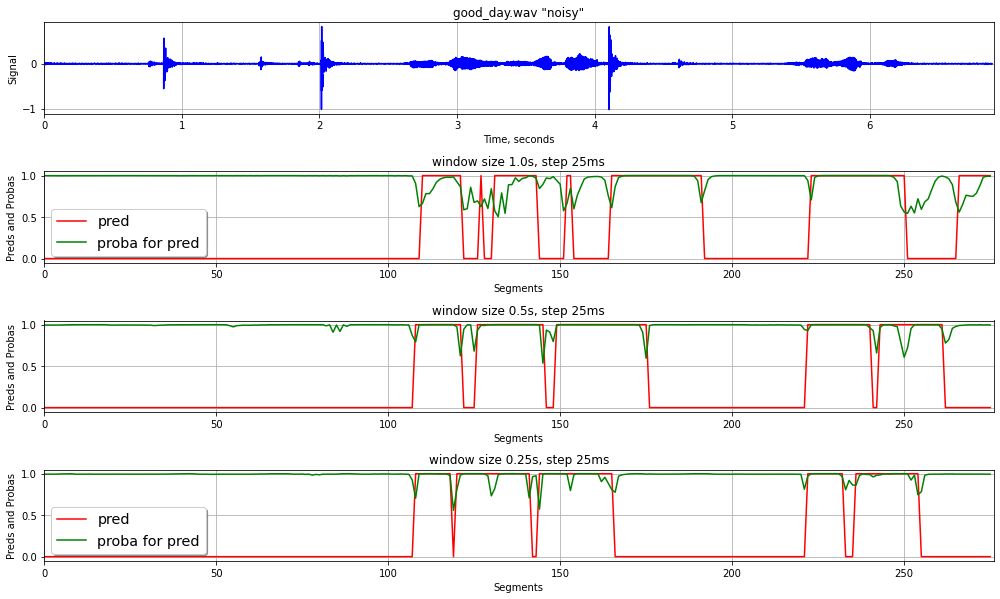

In [154]:
audio, sample_rate = librosa.load(wave_file)


plt.figure(figsize=[14,8])
plt.title('Audio, Predictions and Probas')

plt.subplot(411)
# plt.plot(np.arange(audio.size)/sample_rate audio, 'g')
plt.plot(np.arange(audio.size)/sample_rate, audio, 'b')
plt.xlim([0, len(preds)*FRAME_LEN])
plt.ylabel('Signal')
plt.xlabel('Time, seconds')
plt.gca().set_title('good_day.wav "noisy"')
plt.grid()

plt.subplot(412)
plt.plot(preds_1, 'r', label='pred')
plt.plot(probas_1, 'g', label='proba for pred')
plt.ylabel('Preds and Probas')
plt.xlabel('Segments')
plt.xlim([0, len(preds_1)])
plt.gca().set_title('window size 1.0s, step 25ms')
plt.grid()
legend = plt.legend(loc='lower left', shadow=True, fontsize='x-large')
plt.tight_layout()

plt.subplot(413)
plt.plot(preds_05, 'r', label='pred')
plt.plot(probas_05, 'g', label='proba for pred')
plt.ylabel('Preds and Probas')
plt.xlabel('Segments')
plt.xlim([0, len(preds_05)])
plt.gca().set_title('window size 0.5s, step 25ms')
plt.grid()

plt.subplot(414)
plt.plot(preds_025, 'r', label='pred')
plt.plot(probas_025, 'g', label='proba for pred')
plt.ylabel('Preds and Probas')
plt.xlabel('Segments')
plt.xlim([0, len(preds_025)])
plt.gca().set_title('window size 0.25s, step 25ms')
plt.grid()

legend = plt.legend(loc='lower left', shadow=True, fontsize='x-large')
plt.savefig('good_day_noisy.png')


audio, sample_rate = librosa.load(wave_file)
ipd.Audio(audio, rate=sample_rate)

In [62]:
278/0.025

11120.0

In [128]:
len(preds_05)

278

In [129]:
len(preds_025)

276

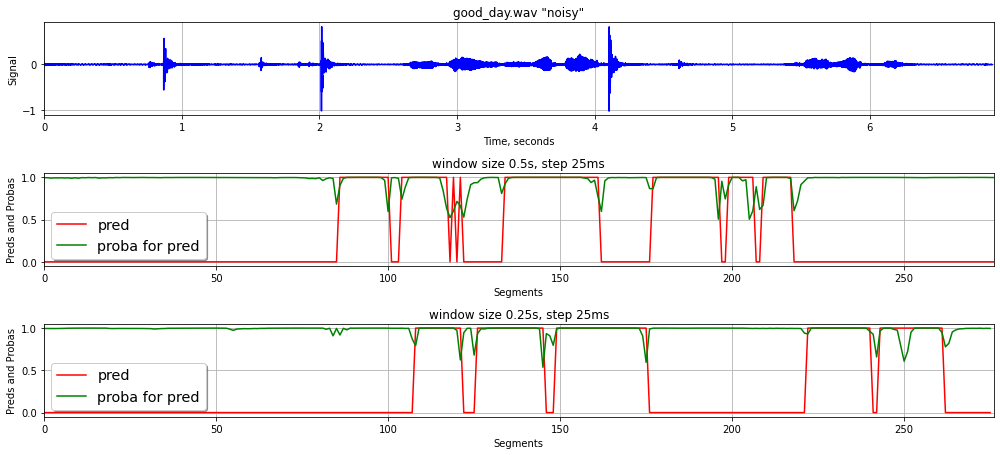

In [134]:
plt.figure(figsize=[14,6])
plt.title('Audio, Predictions and Probas')

ax1 = plt.subplot(311)
# plt.plot(np.arange(audio.size)/sample_rate audio, 'g')
plt.plot(np.arange(audio.size)/sample_rate, audio, 'b')
plt.xlim([0, len(preds)*FRAME_LEN])
plt.ylabel('Signal')
plt.xlabel('Time, seconds')
plt.gca().set_title('good_day.wav "noisy"')
plt.grid()

ax2 = plt.subplot(312)
plt.plot(preds_05, 'r', label='pred')
plt.plot(probas_05, 'g', label='proba for pred')
plt.ylabel('Preds and Probas')
plt.xlabel('Segments')
plt.xlim([0, len(preds)])
plt.gca().set_title('window size 0.5s, step 25ms')
plt.grid()
legend = plt.legend(loc='lower left', shadow=True, fontsize='x-large')
plt.tight_layout()

ax3 = plt.subplot(313)
plt.plot(preds_025, 'r', label='pred')
plt.plot(probas_025, 'g', label='proba for pred')
plt.ylabel('Preds and Probas')
plt.xlabel('Segments')
plt.xlim([0, len(preds)])
plt.gca().set_title('window size 0.25s, step 25ms')
plt.grid()

legend = plt.legend(loc='lower left', shadow=True, fontsize='x-large')
plt.savefig('good_day_noisy.png')

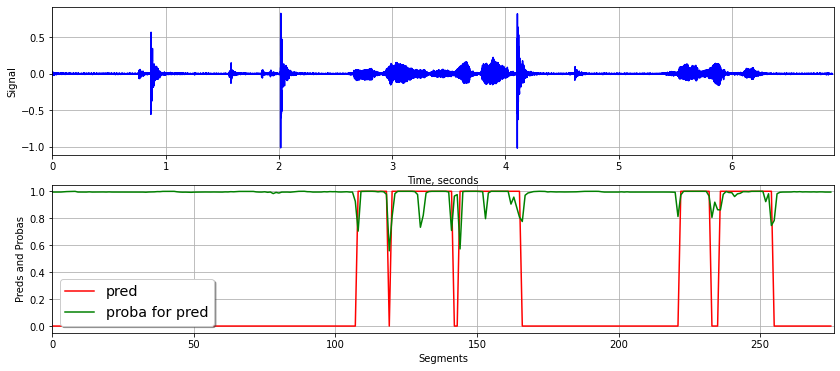

In [86]:
plt.figure(figsize=[14,6])
plt.title('Audio, Predictions and Probas')
plt.subplot(211)
# plt.plot(np.arange(audio.size)/sample_rate audio, 'g')
plt.plot(np.arange(audio.size)/sample_rate, audio, 'b')
plt.xlim([0, len(preds)*FRAME_LEN])
plt.ylabel('Signal')
plt.xlabel('Time, seconds')
plt.grid()

plt.subplot(212)
plt.plot(preds, 'r', label='pred')
plt.plot(probas, 'g', label='proba for pred')
plt.ylabel('Preds and Probas')
plt.xlabel('Segments')
plt.xlim([0, len(preds)])
plt.grid()
legend = plt.legend(loc='lower left', shadow=True, fontsize='x-large')

In [81]:
# wave_file ='/home/fjia/data/freesound_resampled/Baby_cry/id_66637 cryingbabymerged.wav'
wave_file = 'haorizi_noisy_16.wav'

audio, sample_rate = librosa.load(wave_file)
ipd.Audio(audio, rate=sample_rate)

In [63]:
len(np.arange(audio.size)/sample_rate)

152851

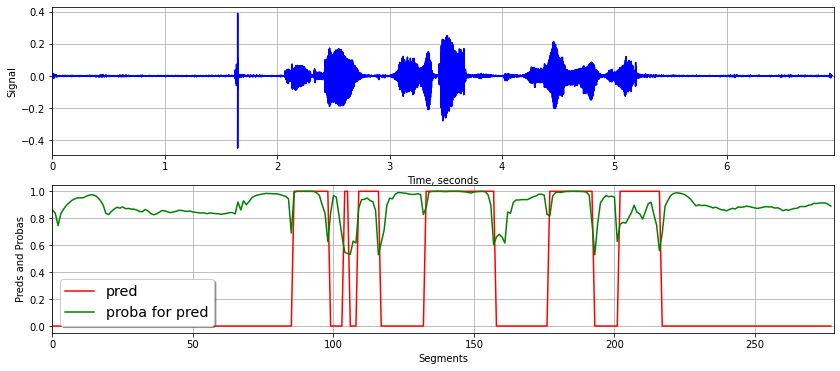

In [123]:
plt.figure(figsize=[14,6])
plt.title('Audio, Predictions and Probas')
plt.subplot(211)
# plt.plot(np.arange(audio.size)/sample_rate audio, 'g')
plt.plot(np.arange(audio.size)/sample_rate, audio, 'b')
plt.xlim([0, len(preds)*FRAME_LEN])
plt.ylabel('Signal')
plt.xlabel('Time, seconds')
plt.grid()

plt.subplot(212)
plt.plot(preds, 'r', label='pred')
plt.plot(probas, 'g', label='proba for pred')
plt.ylabel('Preds and Probas')
plt.xlabel('Segments')
plt.xlim([0, len(preds)])
plt.grid()
legend = plt.legend(loc='lower left', shadow=True, fontsize='x-large')

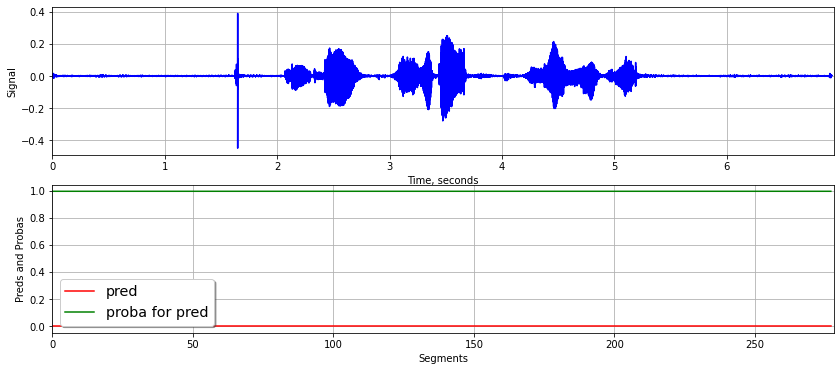

In [26]:
plt.figure(figsize=[14,6])
plt.title('Audio, Predictions and Probas')
plt.subplot(211)
# plt.plot(np.arange(audio.size)/sample_rate audio, 'g')
plt.plot(np.arange(audio.size)/sample_rate, audio, 'b')
plt.xlim([0, len(preds)*FRAME_LEN])
plt.ylabel('Signal')
plt.xlabel('Time, seconds')
plt.grid()

plt.subplot(212)
plt.plot(preds, 'r', label='pred')
plt.plot(probas, 'g', label='proba for pred')
plt.ylabel('Preds and Probas')
plt.xlabel('Segments')
plt.xlim([0, len(preds)])
plt.grid()
legend = plt.legend(loc='lower left', shadow=True, fontsize='x-large')


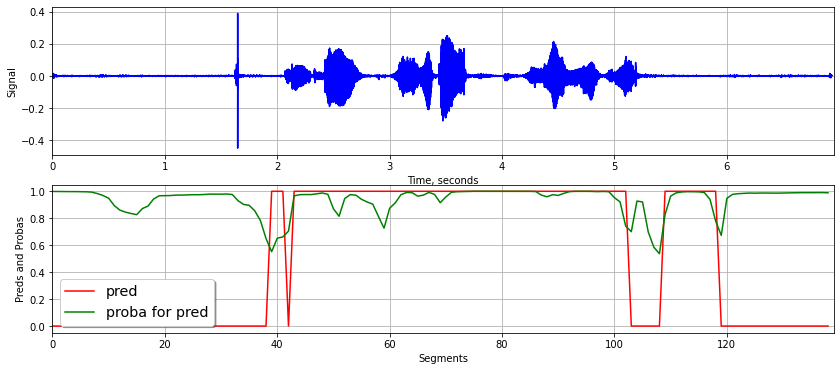

In [79]:
plt.figure(figsize=[14,6])
plt.title('Audio, Predictions and Probas')
plt.subplot(211)
# plt.plot(np.arange(audio.size)/sample_rate audio, 'g')
plt.plot(np.arange(audio.size)/sample_rate, audio, 'b')
plt.xlim([0, len(preds)*FRAME_LEN])
plt.ylabel('Signal')
plt.xlabel('Time, seconds')
plt.grid()

plt.subplot(212)
plt.plot(preds, 'r', label='pred')
plt.plot(probas, 'g', label='proba for pred')
plt.ylabel('Preds and Probas')
plt.xlabel('Segments')
plt.xlim([0, len(preds)])
plt.grid()
legend = plt.legend(loc='lower left', shadow=True, fontsize='x-large')


## Online
[TODO]

In [18]:
p = pa.PyAudio()
print('Available audio input devices:')
for i in range(p.get_device_count()):
    dev = p.get_device_info_by_index(i)
    if dev.get('maxInputChannels'):
        print(i, dev.get('name'))
print('Please type input device ID:')
dev_idx = int(input())

empty_counter = 0

def callback(in_data, frame_count, time_info, status):
    global empty_counter
    signal = np.frombuffer(in_data, dtype=np.int16)
    text = asr.transcribe(signal)
    if len(text):
        print(text,end='')
        empty_counter = 3
    elif empty_counter > 0:
        empty_counter -= 1
        if empty_counter == 0:
            print(' ',end='')
    return (in_data, pa.paContinue)

stream = p.open(format=pa.paInt16,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                input_device_index=dev_idx,
                stream_callback=callback,
                frames_per_buffer=CHUNK_SIZE)

print('Listening...')

stream.start_stream()

while stream.is_active():
    time.sleep(0.1)

Available audio input devices:
0 pulse
1 default
Please type input device ID:


KeyboardInterrupt: Interrupted by user

In [19]:
stream.stop_stream()
stream.close()
p.terminate()